# Dimensionality Reduction Of The PBMC Dataset Using PCA And UMAP

In [1]:
# loading packages
from scipy.io import mmread
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
from scipy.sparse import csr_matrix
import plotly.express as px
from sklearn.decomposition import PCA
import umap
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import seaborn as sns

/hpc/compgen/users/nlandzaat/Software/anaconda3/envs/project_env_test/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/compgen/users/nlandzaat/Software/anaconda3/envs/project_env_test/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/h

## Load data

Load the AnnData file that has been prepared in data_prep_PBMC.

In [2]:
# loading original data 

# define paths
file_path_sparse = "/home/cog/nlandzaat/rep_learning_sc_foundation/raw/PBMC/sparse_matrix_pmbc68kdata.txt"
file_path_out_df = "/home/cog/nlandzaat/rep_learning_sc_foundation/raw/PBMC/df_pmbc68kdata.csv"

# load dataset
with open(file_path_sparse) as matrix_file:
    matrix_sparse = mmread(matrix_file)

df = pd.DataFrame.sparse.from_spmatrix(matrix_sparse)

# load annotations
gene_ID_names = pd.read_csv("/home/cog/nlandzaat/rep_learning_sc_foundation/raw/PBMC/annotatie.csv")
df.columns = gene_ID_names["ENSEMBL_IDS"]


In [3]:
# loading adata

# specify the file path where the AnnData object is saved
adata_file_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/raw/PBMC/adata_PBMC_PCA_UMAP.h5ad"

# load the AnnData object from the specified file path
adata = sc.read(adata_file_path)

/hpc/compgen/users/nlandzaat/Software/anaconda3/envs/project_env_test/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


### Create baseline using PCA (PCA embedding)
Reduce dimensionality of the dataset to a dimensionality of 2. Make PCA baseline embedding on 2000 most varying genes in dataset.
Columns of matrix are the variables (= genes) that we want to use to transform our samples. Samples are the rows of the matrix. 


Focusing on highly variable genes before conducting PCA is important because it helps capture the most informative features that drive cell-to-cell variation, leading to a more effective dimensionality reduction and visualization of the data. By prioritizing these genes, PCA can better uncover the underlying structure and biological differences in the single-cell gene expression dataset.

Scanpy is used to identify highly variable genes from single-cell gene expression data. Using the 'seurat' flavor, it identifies the top 2000 highly variable genes. The results are stored in a pandas DataFrame with gene names and their respective high variability status. The original gene expression DataFrame is then filtered to retain only the expression values of highly variable genes. Now 'highly_variable_gene_expression_df' contains only the highly variable genes.

https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html

## Preprocessing

These following preprocessing steps prepare the data for dimensionality reduction. The preprocessing steps are performed as suggested by the Geneformer. The code utilizes the Scanpy library to preprocess single-cell gene expression data. It first filters out cells with fewer than 10 expressed genes and then genes that are expressed in fewer than 10 cells. Next, it performs total count normalization, scaling the expression values for each cell to a target sum of 10,000. Finally, it applies a logarithmic transformation to stabilize variance across genes. 

In [4]:
# preprocess the AnnData object
sc.pp.filter_cells(adata, min_genes=10)  
sc.pp.filter_genes(adata, min_cells=10)    
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
# identify highly variable genes using Scanpy's function
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)  # Adjust parameters as needed

# get the highly variable genes as a pandas DataFrame
highly_variable_genes_df = pd.DataFrame({
    "gene_name": adata.var_names,
    "highly_variable": adata.var["highly_variable"]
})

In [14]:
# waarom zou je dit doen? dan houd je de data uit original df, maar dat is niet de adata die je gepreprocessed hebt

# filter the original DataFrame to keep only highly variable genes (with cells = rows and genes = cols)
#highly_variable_gene_expression_df = df.iloc[:,np.where(highly_variable_genes_df["highly_variable"])[0]]


In [6]:
# extract the indices of highly variable genes
highly_variable_gene_indices = np.where(highly_variable_genes_df["highly_variable"])[0]

# select columns corresponding to highly variable genes from the AnnData object
highly_variable_gene_expression_df = adata[:, highly_variable_gene_indices].to_df()


## PCA dimensionality reduction 2D

Next, the DataFrame containing highly variable gene expression data is converted into a dense array, ensuring compatibility with PCA, which typically requires dense matrices. The code then defines the number of principal components to retain, creates a PCA model, and fits it to the dense array. Finally, it transforms the data into a lower-dimensional space using PCA and stores the results in a DataFrame (reduced_df_2D), enabling visualization in a two-dimensionsal scatter plot.

In [23]:
# convert sparse elements to dense array
dense_array = np.array([x.toarray().ravel() if pd.api.types.is_sparse(x) else x for x in highly_variable_gene_expression_df.values])

# define the number of principal components to retain
n_components = 2  

# create PCA model and fit it to the dense array
pca_2D = PCA(n_components=n_components)
reduced_data_2D = pca_2D.fit_transform(dense_array)

# convert the result to a DataFrame
reduced_df_2D = pd.DataFrame(reduced_data_2D, columns=[f"PC{i}" for i in range(1, n_components + 1)])

In [24]:
# define the file path where you want to save the DataFrame
file_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/raw/PBMC/reduced_df_2D_PBMC.csv"

# save the DataFrame to a CSV file
reduced_df_2D.to_csv(file_path, index=False)

In [25]:
# create scatter plot 
fig = px.scatter(reduced_data_2D, x=0, y=1,)

# add title and axis labels
fig.update_layout(
    title="2D PCA of PBMC cells",
    xaxis_title="PC1",
    yaxis_title="PC2",
)

fig.show()


## PCA dimensionality reduction to 256D

The dataset's dimensionality is reduced to 256 using PCA. The resulting principal components are then saved to the specified path, capturing the resulting embeddings.

In [8]:
# create PCA model and fit it to the dense array
n_components_256 = 256
pca_256D = PCA(n_components=n_components_256)
reduced_data_256D = pca_256D.fit_transform(dense_array)

In [11]:
# convert the result to a DataFrame
reduced_df_256D = pd.DataFrame(reduced_data_256D, columns=[f"PC{i}" for i in range(1, n_components_256 + 1)])

# save the embeddings to a CSV file
embedding_file_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/PCA_embeddings_PBMC_256.csv"
reduced_df_256D.to_csv(embedding_file_path, index=False)

PCA dimensionality reduction has been performed on the dataset, reducing it to 256 dimensions. The reduced data is visualized in a 2D UMAP.

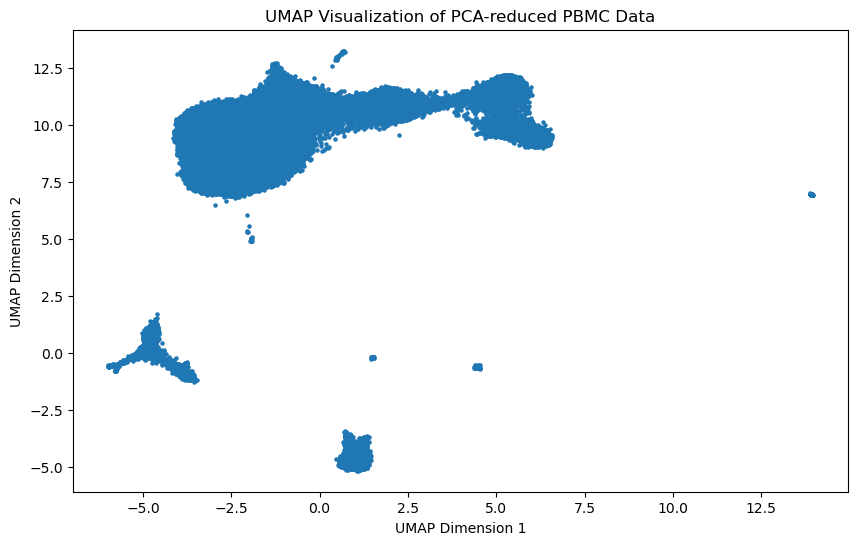

In [22]:
# apply UMAP
umap = UMAP(n_components=2)  
X_umap = umap.fit_transform(reduced_data_256D)

# visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=5)
plt.title("UMAP Visualization of PCA-reduced PBMC Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


The following code creates a scree plot. In PCA, eigenvalues represent the proportion of variance explained by each principal component, ranging from 0 to 1. A scree plot shows the eigenvalues of the principal components of a PCA. It is used to visually asses the amount of variance captured by each principal component.

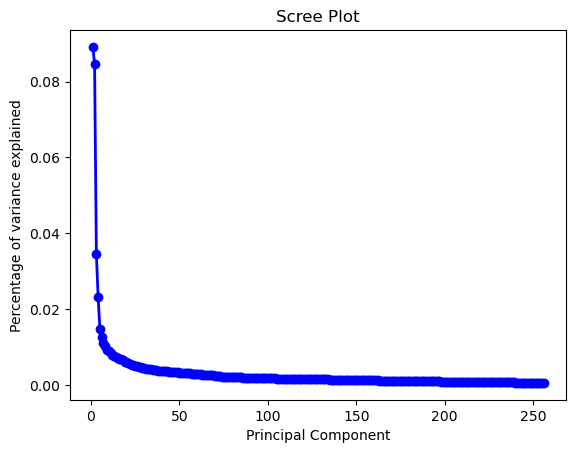

In [9]:
# plot a scree plot to visualize the eigenvalues
PC_values = np.arange(pca_256D.n_components_) + 1
plt.plot(PC_values, pca_256D.explained_variance_ratio_, "o-", linewidth=2, color="blue")
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Percentage of variance explained")
plt.show()

In [14]:
# explained variance ratio for the first two principal components
print(pca_2D.explained_variance_ratio_)

[0.08911332 0.08471534]


## UMAP original dataset to 2D

This code segment applies UMAP to visualize high-dimensional single-cell data from the provided AnnData object in a two-dimensional space, preserving both local and global structure. The resulting "umap_reduced_2" variable contains the coordinates for each data point in the reduced space, facilitating 2D visualization.

In [15]:
# UMAP original data to 2

# apply UMAP on adata
umap = UMAP(n_components=2)
umap_reduced_2 = umap.fit_transform(adata.X)

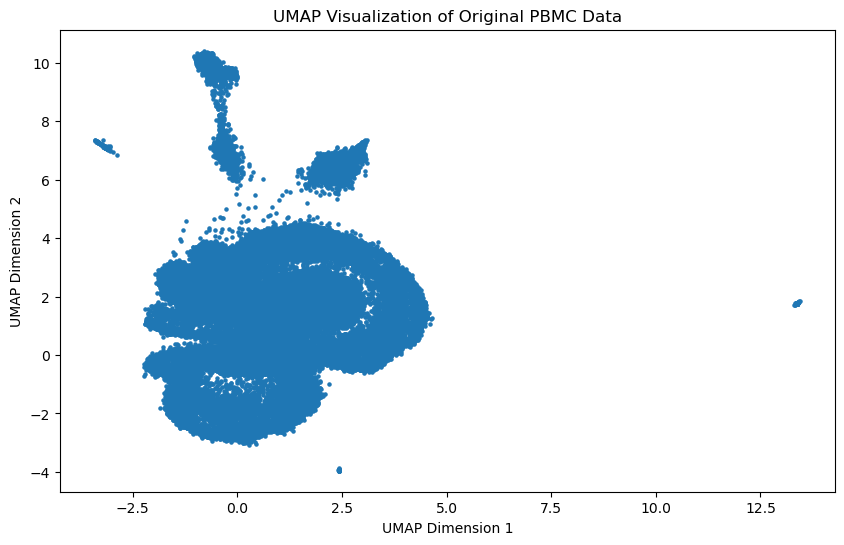

In [21]:
# visualize 
plt.figure(figsize=(10, 6))
plt.scatter(umap_reduced_2[:, 0], umap_reduced_2[:, 1], s=5)
plt.title("UMAP Visualization of Original PBMC Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

## UMAP dimensionality reduction 256D

UMAP is applied to the original dataset to reduce the dimensionality to 256D. The resulting embeddings are saved to the specified path.

In [17]:
# UMAP original data to 256

# apply UMAP on adata
umap = UMAP(n_components=256)
umap_reduced_256 = umap.fit_transform(adata.X)

In [18]:
# create a DataFrame containing the UMAP embeddings
umap_embeddings_df = pd.DataFrame(umap_reduced_256, columns=[f"UMAP_{i}" for i in range(256)])

# save the embeddings to a CSV file
embedding_file_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/UMAP_embeddings_PBMC.csv"
umap_embeddings_df.to_csv(embedding_file_path, index=False)

     UMAP_0    UMAP_1    UMAP_2    UMAP_3    UMAP_4    UMAP_5    UMAP_6  \
0  9.483392  8.872919  0.335753  8.277049  5.940185  9.118301  6.357625   
1  9.488892  8.819489  0.336369  8.242642  5.920119  9.125005  6.360081   
2  9.484554  8.889305  0.334946  8.285030  5.956158  9.119448  6.356429   
3  9.608317  7.047394  0.758346  5.990842  4.466501  9.303328  6.640382   
4  9.483273  8.869666  0.333830  8.269685  5.951957  9.122033  6.360349   

     UMAP_7    UMAP_8    UMAP_9  ...  UMAP_246  UMAP_247  UMAP_248  UMAP_249  \
0  4.317945  4.351614  3.494236  ...  5.830955  4.853710  5.658818  5.281261   
1  4.322028  4.341320  3.510631  ...  5.835782  4.827852  5.688662  5.277372   
2  4.323478  4.357674  3.470446  ...  5.829873  4.851906  5.672058  5.266557   
3  4.188945  3.687500  3.369781  ...  5.843823  4.705956  5.628801  5.450592   
4  4.322862  4.350101  3.453510  ...  5.828402  4.860541  5.675244  5.252245   

   UMAP_250  UMAP_251  UMAP_252  UMAP_253  UMAP_254  UMAP_255  
0  5

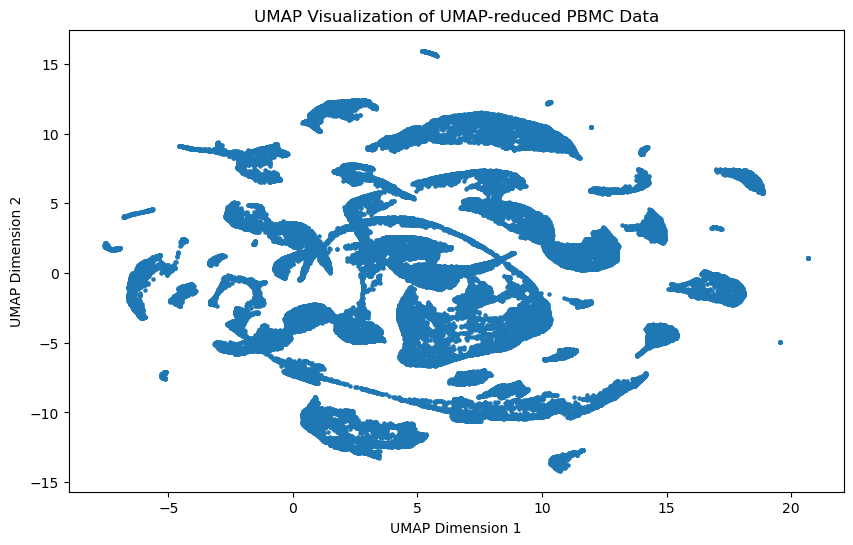

In [23]:
# apply UMAP
umap = UMAP(n_components=2)  # You can choose 2 or 3 for visualization
umap_256 = umap.fit_transform(umap_reduced_256)

# visualize
plt.figure(figsize=(10, 6))
plt.scatter(umap_256[:, 0], umap_256[:, 1], s=5)
plt.title("UMAP Visualization of UMAP-reduced PBMC Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()
